In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.graphics.tsaplots import plot_pacf

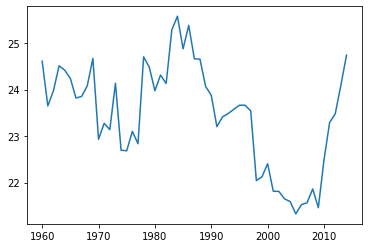

In [2]:
df = pd.read_excel(r'/TUGAS 2.xlsx', parse_dates=['YEAR'], index_col = 'YEAR')
df.head()
plt.plot(df)

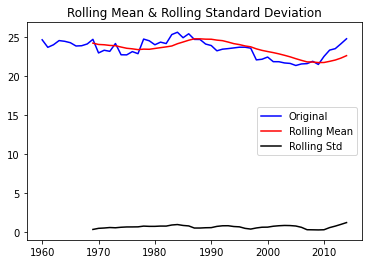

In [3]:
rolling_mean = df.rolling(window = 10).mean()
rolling_std = df.rolling(window = 10).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [4]:
result = adfuller(df['EMISSION'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.0980770719457253
p-value: 0.24528852324440065
Critical Values:
	1%: -3.55770911573439
	5%: -2.9167703434435808
	10%: -2.59622219478738


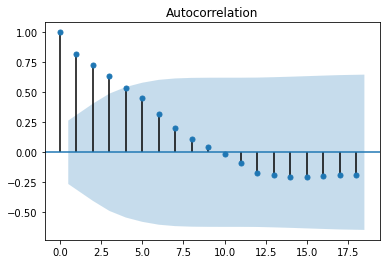

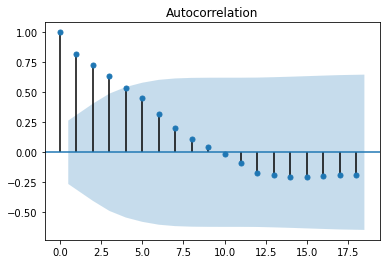

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['EMISSION'])

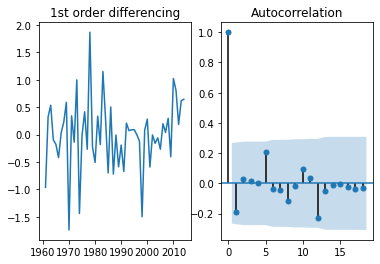

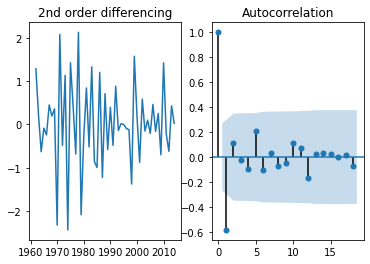

In [6]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(df.diff())

ax2 = f.add_subplot(122)
plot_acf(df.diff().dropna(), ax=ax2)
plt.show()

g = plt.figure()
ax1 = g.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(df.diff().diff())

ax2 = g.add_subplot(122)
plot_acf(df.diff().diff().dropna(), ax=ax2)
plt.show()

#number of differencing (d) = 2 (second order differencing)


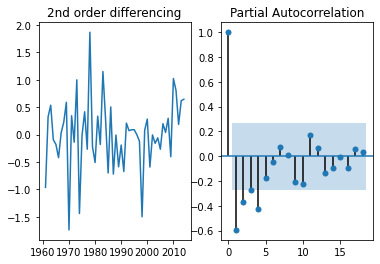

In [7]:
h = plt.figure()
ax1 = h.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(df.diff())

ax2 = h.add_subplot(122)
plot_pacf(df.diff().diff().dropna(), ax=ax2)
plt.show()

#from partial autocorrelation, 1st lag is the most significant so p = 1
#from autocorrelation, there's 1 lag crossing the boundary so q = 1

In [8]:
#order = p, d, q

arima_model = ARIMA(df[:80], order=(1,2,1))
model = arima_model.fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.EMISSION   No. Observations:                   53
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -52.006
Method:                       css-mle   S.D. of innovations              0.619
Date:                Mon, 26 Sep 2022   AIC                            112.011
Time:                        13:33:02   BIC                            119.893
Sample:                    01-01-1962   HQIC                           115.042
                         - 01-01-2014                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0046      0.005      1.011      0.312      -0.004       0.014
ar.L1.D2.EMISSION    -0.1918      0.137     -1.396      0.163      -0.461       0.077
ma.L1.D2.EMISSION    -1.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will b

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


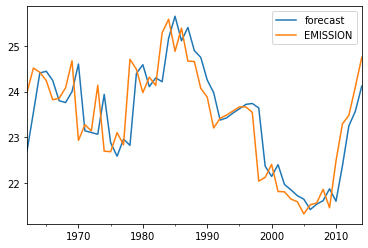

In [9]:
model.plot_predict(dynamic=False)
plt.show()

[Text(0, 0.5, 'CO2 EMISSION KILOTON')]

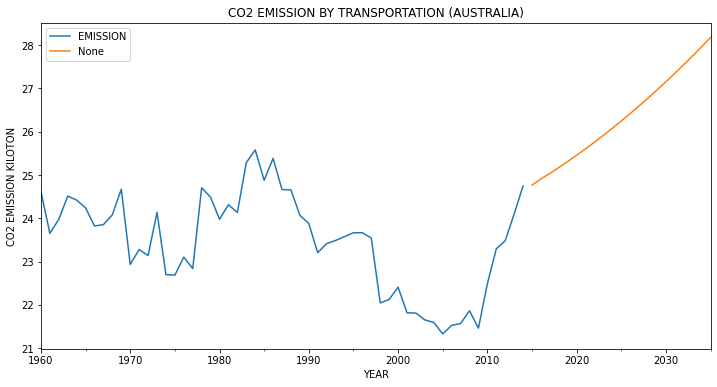

In [13]:
#full_model = SARIMAX(df['Sales'],order=(3,1,0),seasonal_order=(1,1,1,12))
#res2 = full_model.fit()
forecast = model.predict(len(df),len(df)+20,typ='levels')
ax = df['EMISSION'].plot(legend = True, figsize=(12,6), title = 'CO2 EMISSION BY TRANSPORTATION (AUSTRALIA)')
forecast.plot(legend = True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel = 'CO2 EMISSION KILOTON')

In [10]:
y_pred = pd.Series(model.forecast(20)[0], index=df[:20].index)
y_true = df['EMISSION'][:20]
print(np.array(y_pred).astype(np.uint8))
print(np.array(y_true))

#datanya belum dibagi

mape = np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred - y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5
corr = np.corrcoef(y_pred, y_true)

mins = np.amin(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
maxs = np.amax(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
minmax = 1 - np.mean(mins/maxs)

import pprint
pprint.pprint({'mape': mape, 'mae': mae,
               'mpe': mpe, 'rmse': rmse,
               'corr': corr, 'minmax': minmax})

[24 24 25 25 25 25 25 25 25 26 26 26 26 26 26 27 27 27 27 27]
[24.61277558 23.65041358 23.97642353 24.51311606 24.41970183 24.24080029
 23.82095695 23.85358331 24.08204025 24.67199296 22.93299442 23.27706473
 23.13860252 24.1377124  22.69750188 22.68598495 23.10314493 22.837017
 24.70563609 24.4857635 ]
{'corr': array([[ 1.        , -0.34771582],
       [-0.34771582,  1.        ]]),
 'mae': 2.4467407618175043,
 'mape': 0.10418282982490132,
 'minmax': 0.09167097499797983,
 'mpe': 0.10418282982490132,
 'rmse': 2.8029720070829307}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  from ipykernel import kernelapp as app
